In [1]:
# Image
from IPython import display

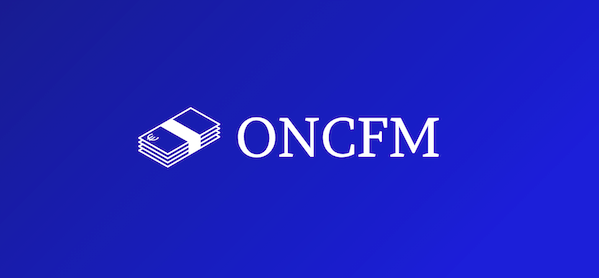

In [2]:
display.Image('./LOGO.png')

# <span style='color:blue'>**K-means**</span>

Méthode de classification non supervisé, qui recherche les proximités entre individus ou entre variables pour construire des groupes homogènes d'individus.

# Librairies

In [3]:
# Librairies traitement de données
import pandas as pd
import numpy as np

# Librairies graphiques
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set_style('darkgrid')

# Librairie analyse 
from sklearn import preprocessing, decomposition
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

#Warning
import warnings
warnings.filterwarnings('ignore')

# Fonctions

In [4]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# Importation des données

In [5]:
# Importation du fichier csv
billet = pd.read_csv('billet_ad.csv')
# Résultat
billet.head()

,Unnamed: 0,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [6]:
# Suppression de la colonne 'Unnamed:0'
billet = billet.drop(columns={'Unnamed: 0'})
# Résultat
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [7]:
# Dimension
billet.shape

(1500, 7)

In [8]:
# Informations
billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


# ACP

Pour étudier la variablité entre les individus et les liaisons entre les variables, je réalise une analyse des composantes principales (ACP).

*Au vu de l'analyse descriptive, je réalise donc mon acp directement.*

## Calcul de l'ACP

In [9]:
# Je conserve uniquement les variables numériques
billet_acp = billet.select_dtypes(include='float')

In [10]:
# Récupération du nombre de variables et d'observations
n = billet_acp.shape[0] # Nombre d'observations
p = billet_acp.shape[1] # Nombre de variables
print('Le nombre d\'observations est de',n,' et le nombre de variables est de',p)

Le nombre d'observations est de 1500  et le nombre de variables est de 6


In [11]:
# Transformation des données en array numpy
X = billet_acp.values
id_billet = billet_acp.index
features = billet_acp.columns

In [12]:
# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [13]:
# Vérification moyenne
print(np.mean(X_scaled, axis=0))

[-7.85054984e-14  4.81274280e-14 -2.78343274e-14 -9.09494702e-16
 -9.85285927e-16  4.54747351e-16]


In [14]:
# Vérification de l'écart-type
print(np.std(X_scaled, axis=0))

[1. 1. 1. 1. 1. 1.]


> Le centrage et la réduction ont bien fonctionné.

Je recherche le nombre de dimensions le plus juste pour préserver 95% de la variance.

In [15]:
# Recherche du bon nombre de dimensions
pca = decomposition.PCA(n_components=0.95)    # Calcul pour préserver 95% de la variance
pca.fit(X_scaled)

PCA(n_components=0.95)

In [16]:
# Taux de variance
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.43204935 0.16957137 0.13019944 0.11825183 0.09666912 0.0532589 ]
1.0


> Pour conserver 95% de la variance, il faut **réduire au 6 premières composantes principales.**

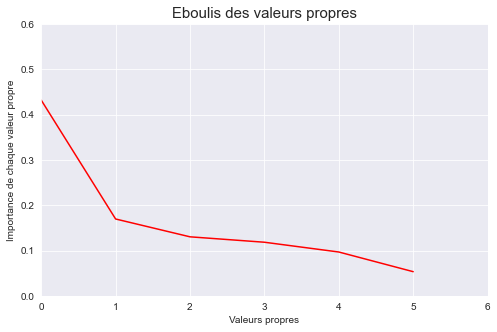

In [17]:
# Visualisation de l'éboulis des valeurs propres
plt.figure(figsize=(8,5))

# Courbe
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color='red')

# Titres
plt.title('Eboulis des valeurs propres', fontsize=15)
plt.xlabel('Valeurs propres')
plt.ylabel('Importance de chaque valeur propre')
# Limites du graphique
plt.xlim([0,6])
plt.ylim([0,0.6])

plt.show()

> L'éboulis des valeurs propres confirme que la **première composante principale possède près de 50% de la variance.**

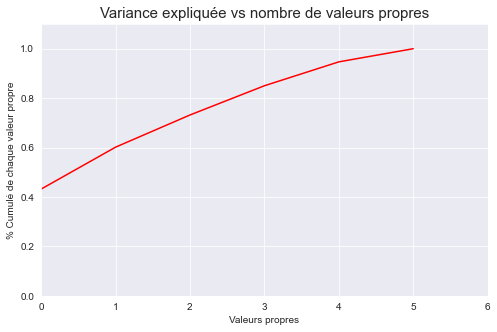

In [18]:
# Visualisation du cumul de la variance expliquée
plt.figure(figsize=(8,5))

# Courbe
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), color='red')

# Limites du graphique
plt.xlim([0,6])
plt.ylim([0,1.1])

# Titres
plt.title('Variance expliquée vs nombre de valeurs propres', fontsize=15)
plt.xlabel('Valeurs propres')
plt.ylabel('% Cumulé de chaque valeur propre')

plt.show()

>Le graphique du **cumule de la variance expliquée** confirme le fait qu'avec la réduction aux 6 premières composantes principales, il y a **près de 100% de la variance conservée**.

## Cercle des corrélations

Le cercle des corrélation va nous permettre de savoir s'il y a des variables corrélées entre elles.

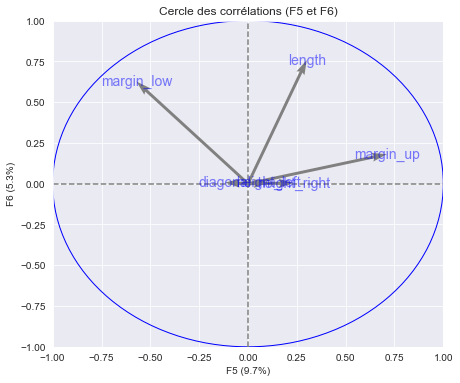

In [45]:
pcs = pca.components_
display_circles(pcs, 6, pca, [(4,5)], labels = np.array(features))

Observations :
- Sur le 1er plan factoriel : 'diagonal' est fortement corrélée positivement à F2.
- Sur le 2nd plan factoriel : 'height_right' est fortement corrélée positivement à F4 et 'height_left' est fortement corrélée positivement à F3.
- Sur le 3ème plan factoriel : 'margin_up' est fortement corrélée positivement à F5 et 'length' et 'margin_low' sont fortement corrélées positivement à F6.

> **On retrouve la corrélation entre 'length' et 'margin_low'.**

In [20]:
# df centré réduit
df_normalise = pd.DataFrame(X_scaled, columns=features, index=id_billet)
# Résultat
df_normalise.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.056300,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.080703,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.125620,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.308103,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.671382,1.417677,-0.158750


In [21]:
# Dimension
df_normalise.shape

(1500, 6)

In [22]:
# df avec les composantes principales
X_projected = pca.fit_transform(X_scaled)
composantes_principales = pd.DataFrame(X_projected, index=df_normalise.index, columns=['F'+str(i+1) for i in range(6)])
# Résultat 
composantes_principales.head()

,F1,F2,F3,F4,F5,F6
0,1.647209,0.747235,2.395672,3.185117,0.298422,-0.009055
1,-2.019737,-2.206741,-1.002349,0.072101,0.038243,-0.475539
2,-0.968993,2.619321,1.200479,-0.924202,-0.836975,0.196348
3,-1.375758,-1.817656,0.647826,0.831861,0.802583,-0.224417
4,0.150385,-0.566191,0.853477,-1.782991,1.187610,-0.291424


## Projection des individus

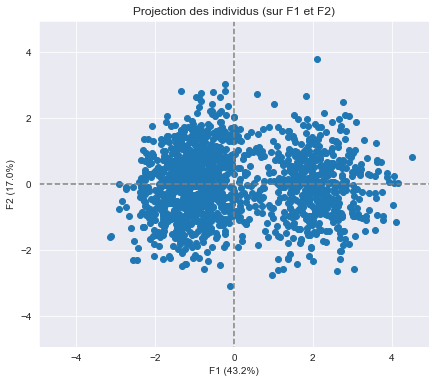

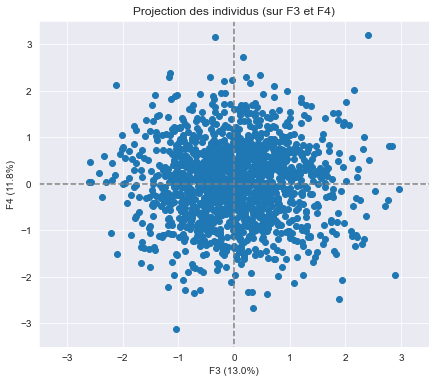

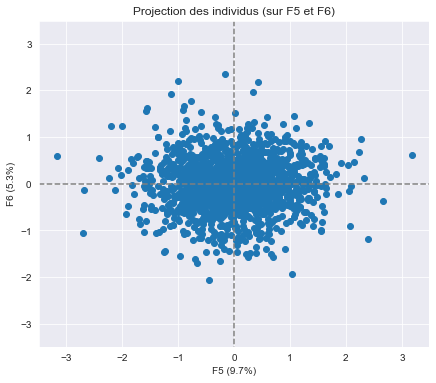

In [23]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, 6, pca, [(0,1),(2,3),(4,5)])

> **Sur le 1er plan factoriel, on voit clairement 2 groupes de points.** Les 2 autres plans factoriels ne sont pas clairement parlant.

# Kmeans

Avant de lancer la méthode Kmeans, je regarde le nombre de clusters qui offre le plus de stabilité. *(même si dans la logique du sujet le nombre de clusters attendu est de 2.)*

## Coefficient de Silhouette

[0.34345999 0.20975456 0.1955754  0.15721098 0.14980782 0.14642656
 0.14530221 0.13831126 0.14209629]


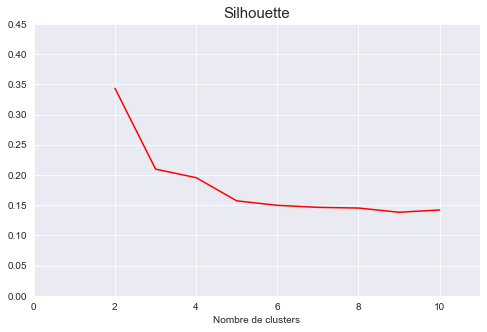

In [24]:
# Importation de la librairie 
from sklearn import metrics

# Variation du nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = KMeans(n_clusters=k+2)
    km.fit(X_scaled)
    res[k] = metrics.silhouette_score(X_scaled,km.labels_)
print(res)

# Visualisation
plt.figure(figsize=(8,5))
plt.title('Silhouette', fontsize=15)
plt.xlabel('Nombre de clusters')
plt.plot(np.arange(2,11,1),res, color='red')

# Limites du graphique
plt.xlim([0,11])
plt.ylim([0,0.45])
plt.show()

> Le coefficient de Silhouette montre une meilleure stabilité avec **2 clusters**.

## Elbow

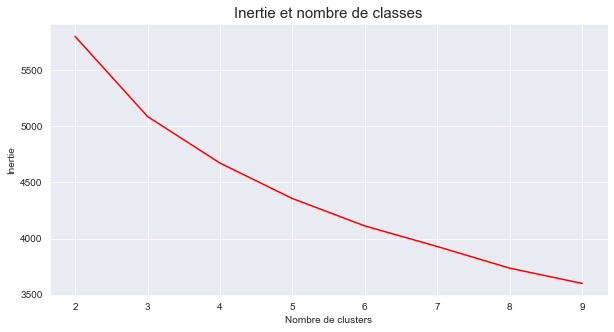

In [25]:
# Création d'une liste pour stocker les inerties
inerties = []
# On fait une boucle de 2 à 9 pour tester toutes les possibilités
for k in range(2,10):
    # Pour chaque k on créé un modèle et on l'ajuste
    kmeans= KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    # Stockage de l'inertie associée
    inerties.append(kmeans.inertia_)

# Visualisation
plt.figure(figsize=(10,5))
plt.plot(range(2,10), inerties, color='red')

#Ajout de texte
plt.title('Inertie et nombre de classes', fontsize=15)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')

plt.show()

>Avec la méthode du coude le **nombre de clusters serait de 3**.

## Kmeans

<Figure size 720x648 with 0 Axes>

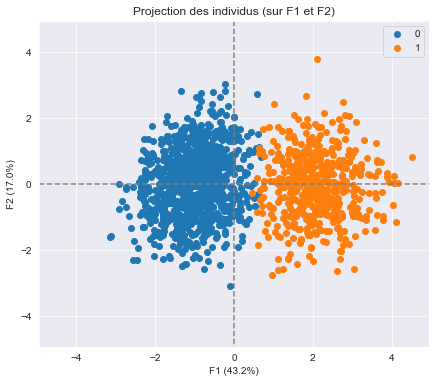

In [26]:
# Pour conserver la pertinence face au sujet, je pars sur 2 clusters
n_clust = 2

# Clustering par K-means
km = KMeans(n_clusters=n_clust, init='k-means++')
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
plt.figure(figsize=(10,9))
display_factorial_planes(X_projected,2, pca, [(0,1)], illustrative_var=clusters)


> On retrouve nos 2 groupes distincts.

## Centroïdes

In [27]:
# Création d'un df avec le nombre de billets par clusters
count = pd.DataFrame(np.unique(clusters, return_counts=True)[1], columns=['Nombre de billets'])

# Stockage des centroïdes des clusters dans un df
centroide = pd.DataFrame(km.cluster_centers_, columns=features)

# Affichage de la concaténation de count et centroide dans un nouveau df
df_centroide = pd.concat([count, pd.DataFrame(centroide, columns=features)], axis=1)
df_centroide

,Nombre de billets,diagonal,height_left,height_right,margin_low,margin_up,length
0,1003,0.096124,-0.281762,-0.352065,-0.553873,-0.428505,0.594584
1,497,-0.193988,0.568627,0.710506,1.117777,0.864769,-1.199935


>Les résultats sont proches de la répartition vrai/faux billets, puisque nous avons au départ 1000 vrais billets et 500 faux billets dans notre jeu de données.

In [28]:
# Initialisation du type de billet (vrai ou faux)
vraiBillet = max(df_centroide['Nombre de billets'])
fauxBillet = min(df_centroide['Nombre de billets'])

In [29]:
# Nommage des clusters
gpe_vrai, gpe_faux = [0 if i==vraiBillet else 1 for i in df_centroide['Nombre de billets']]
# Résultat
print('Les vrais billets appartiennent au cluster',gpe_vrai,' et les faux billets appartiennent au cluster ',gpe_faux)

Les vrais billets appartiennent au cluster 0  et les faux billets appartiennent au cluster  1


# Performance du modèle

## Matrice de confusion

In [30]:
# Nouveau df avec l'ajout des centroïdes
billet['label'] = clusters
# Résultat
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,label
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,0
2,True,172.69,104.48,103.50,4.40,2.94,113.16,0
3,True,171.36,103.91,103.94,3.62,3.01,113.51,0
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0


In [31]:
# Ajout de la colonne 'res_kmeans'
billet['res_kmeans'] = [True if i==gpe_vrai else False for i in billet['label']]
# Résultat
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,label,res_kmeans
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1,False
1,True,171.46,103.36,103.66,3.77,2.99,113.09,0,True
2,True,172.69,104.48,103.50,4.40,2.94,113.16,0,True
3,True,171.36,103.91,103.94,3.62,3.01,113.51,0,True
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0,True


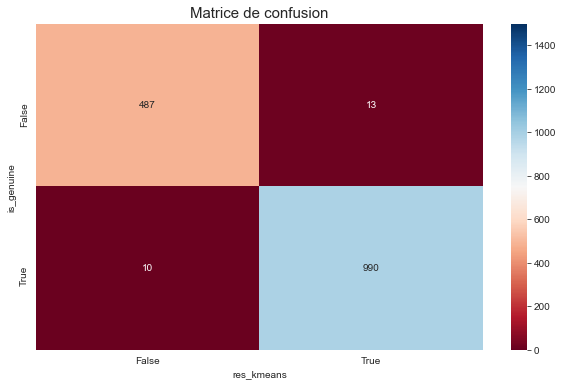

In [32]:
# Matrice de confusion
matrice_confusion = pd.crosstab(billet['is_genuine'],billet['res_kmeans'])
# Visualisation avec une heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(matrice_confusion, cmap='RdBu', vmin=0, vmax=1500, annot=True, fmt='d')
plt.title('Matrice de confusion', fontsize=15)
plt.show()

On observe que notre modèle a détecté :
- 990 vrais positifs
- 13 faux positifs
- 487 vrais négatifs
- 10 faux négatifs

## Mesure de performance

In [33]:
# Test de la qualité du modèle
print(metrics.classification_report(billet['is_genuine'], billet['res_kmeans']))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       500
        True       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



Il y a un **taux de reconnaissance de 98%**.

# Fonctionnement de l'algorithme sur le fichier production

## Importation du fichier

In [34]:
# Importation
billets_prodKmeans = pd.read_csv('billets_production.csv')
# Résultat
billets_prodKmeans

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [35]:
# Mise en index de la colonne 'id'
billets_prodKmeans = billets_prodKmeans.set_index('id')
# Résultat
billets_prodKmeans

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42
A_2,171.87,104.17,104.13,6.00,3.31,112.09
A_3,172.00,104.58,104.29,4.99,3.39,111.57
A_4,172.49,104.55,104.34,4.44,3.03,113.20
A_5,171.65,103.63,103.56,3.77,3.16,113.33


In [36]:
# Dimensions
billets_prodKmeans.shape

(5, 6)

In [37]:
# Informations
billets_prodKmeans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, A_1 to A_5
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
dtypes: float64(6)
memory usage: 280.0+ bytes


# Lancement de l'algorithme

### Centrage et réduction

Comme précédemment je réduit et centre mes données.

In [38]:
# Transformation des données en array numpy
X_prod = billets_prodKmeans.values
id_billetProd = billets_prodKmeans.index
features_prod = billets_prodKmeans.columns

In [39]:
# Centrage et réduction
std_scale_prod = preprocessing.StandardScaler().fit(X_prod)
X_scaled_prod = std_scale_prod.transform(X_prod)

In [40]:
# Vérification moyenne
print(np.mean(X_scaled_prod, axis=0))

[-1.94511074e-14 -4.80948614e-14 -5.65769653e-14 -5.77315973e-16
  3.48610030e-15 -3.55271368e-15]


In [41]:
# Vérification de l'écart-type
print(np.std(X_scaled_prod, axis=0))

[1. 1. 1. 1. 1. 1.]


> Le centrage et la réduction ont fonctionné.

### Prédiction

In [42]:
# Stockage des résulats dans le df
billets_prodKmeans['label'] = km.predict(X_scaled_prod)
# Résultat
billets_prodKmeans

,diagonal,height_left,height_right,margin_low,margin_up,length,label
id,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,1
A_2,171.87,104.17,104.13,6.00,3.31,112.09,1
A_3,172.00,104.58,104.29,4.99,3.39,111.57,1
A_4,172.49,104.55,104.34,4.44,3.03,113.20,0
A_5,171.65,103.63,103.56,3.77,3.16,113.33,0


In [43]:
# Ajout de la colonne 'is_genuine'
billets_prodKmeans['is_genuine'] = [True if i==gpe_vrai else False for i in billets_prodKmeans['label']]
# Résultat
billets_prodKmeans

,diagonal,height_left,height_right,margin_low,margin_up,length,label,is_genuine
id,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,1,False
A_2,171.87,104.17,104.13,6.00,3.31,112.09,1,False
A_3,172.00,104.58,104.29,4.99,3.39,111.57,1,False
A_4,172.49,104.55,104.34,4.44,3.03,113.20,0,True
A_5,171.65,103.63,103.56,3.77,3.16,113.33,0,True


# Export du df

In [44]:
# Export au format csv
billets_prodKmeans.to_csv('billets_prodKmeans.csv')